In [1]:
from pathlib import Path

while Path.cwd().name != 'ambient':
    %cd ..

/mmfs1/gscratch/xlab/alisaliu/ambient


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from matplotlib_venn import venn3, venn3_circles

### ambiguity categories

In [4]:
category_df = pd.read_json('AmbiEnt/analysis/category_annotations.jsonl', lines=True)

In [5]:
cats = Counter()
for i, row in category_df.iterrows():
    row_cats = row['category'].split(', ')
    for row_cat in row_cats:
        cats[row_cat] += 1

In [6]:
cats = {k:np.round(v/sum(cats.values()),3) for k,v in cats.items()}
cats

{'pragmatic': 0.448,
 'lexical': 0.2,
 'syntactic': 0.086,
 'coreferential': 0.029,
 'other': 0.143,
 'scopal': 0.076,
 'figurative': 0.019}

### label distribution

In [8]:
df = pd.read_json('AmbiEnt/ambient_full.jsonl', lines=True)

In [9]:
label_dist = Counter()
for i, row in df.iterrows():
    l = ', '.join(sorted(row['labels'].split(', ')))
    label_dist[l] += 1

In [10]:
key_order = ['entailment', 'neutral', 'entailment, neutral', 'contradiction', 'contradiction, entailment', 'contradiction, neutral', 'contradiction, entailment, neutral']
label_dist

Counter({'entailment, neutral': 330,
         'contradiction, entailment, neutral': 17,
         'contradiction, neutral': 167,
         'contradiction, entailment': 65,
         'neutral': 682,
         'contradiction': 151,
         'entailment': 233})

In [11]:
def darken_color(hex_color, amount=0.2):
    """
    Darken a hexadecimal color code by a given amount.

    Args:
        hex_color (str): The input hexadecimal color code.
        amount (float): The amount by which to darken the color. A value between 0 and 1.
                       Default is 0.2, which darkens the color by 20%.

    Returns:
        str: The darker hexadecimal color code.
    """
    # Convert the hexadecimal color code to RGB
    hex_color = hex_color.strip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    # Darken the RGB color by the given amount
    r, g, b = rgb
    darkened_r = max(0, r - int(r * amount))
    darkened_g = max(0, g - int(g * amount))
    darkened_b = max(0, b - int(b * amount))

    # Convert the darkened RGB color back to hexadecimal
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(darkened_r, darkened_g, darkened_b)

    return darkened_hex

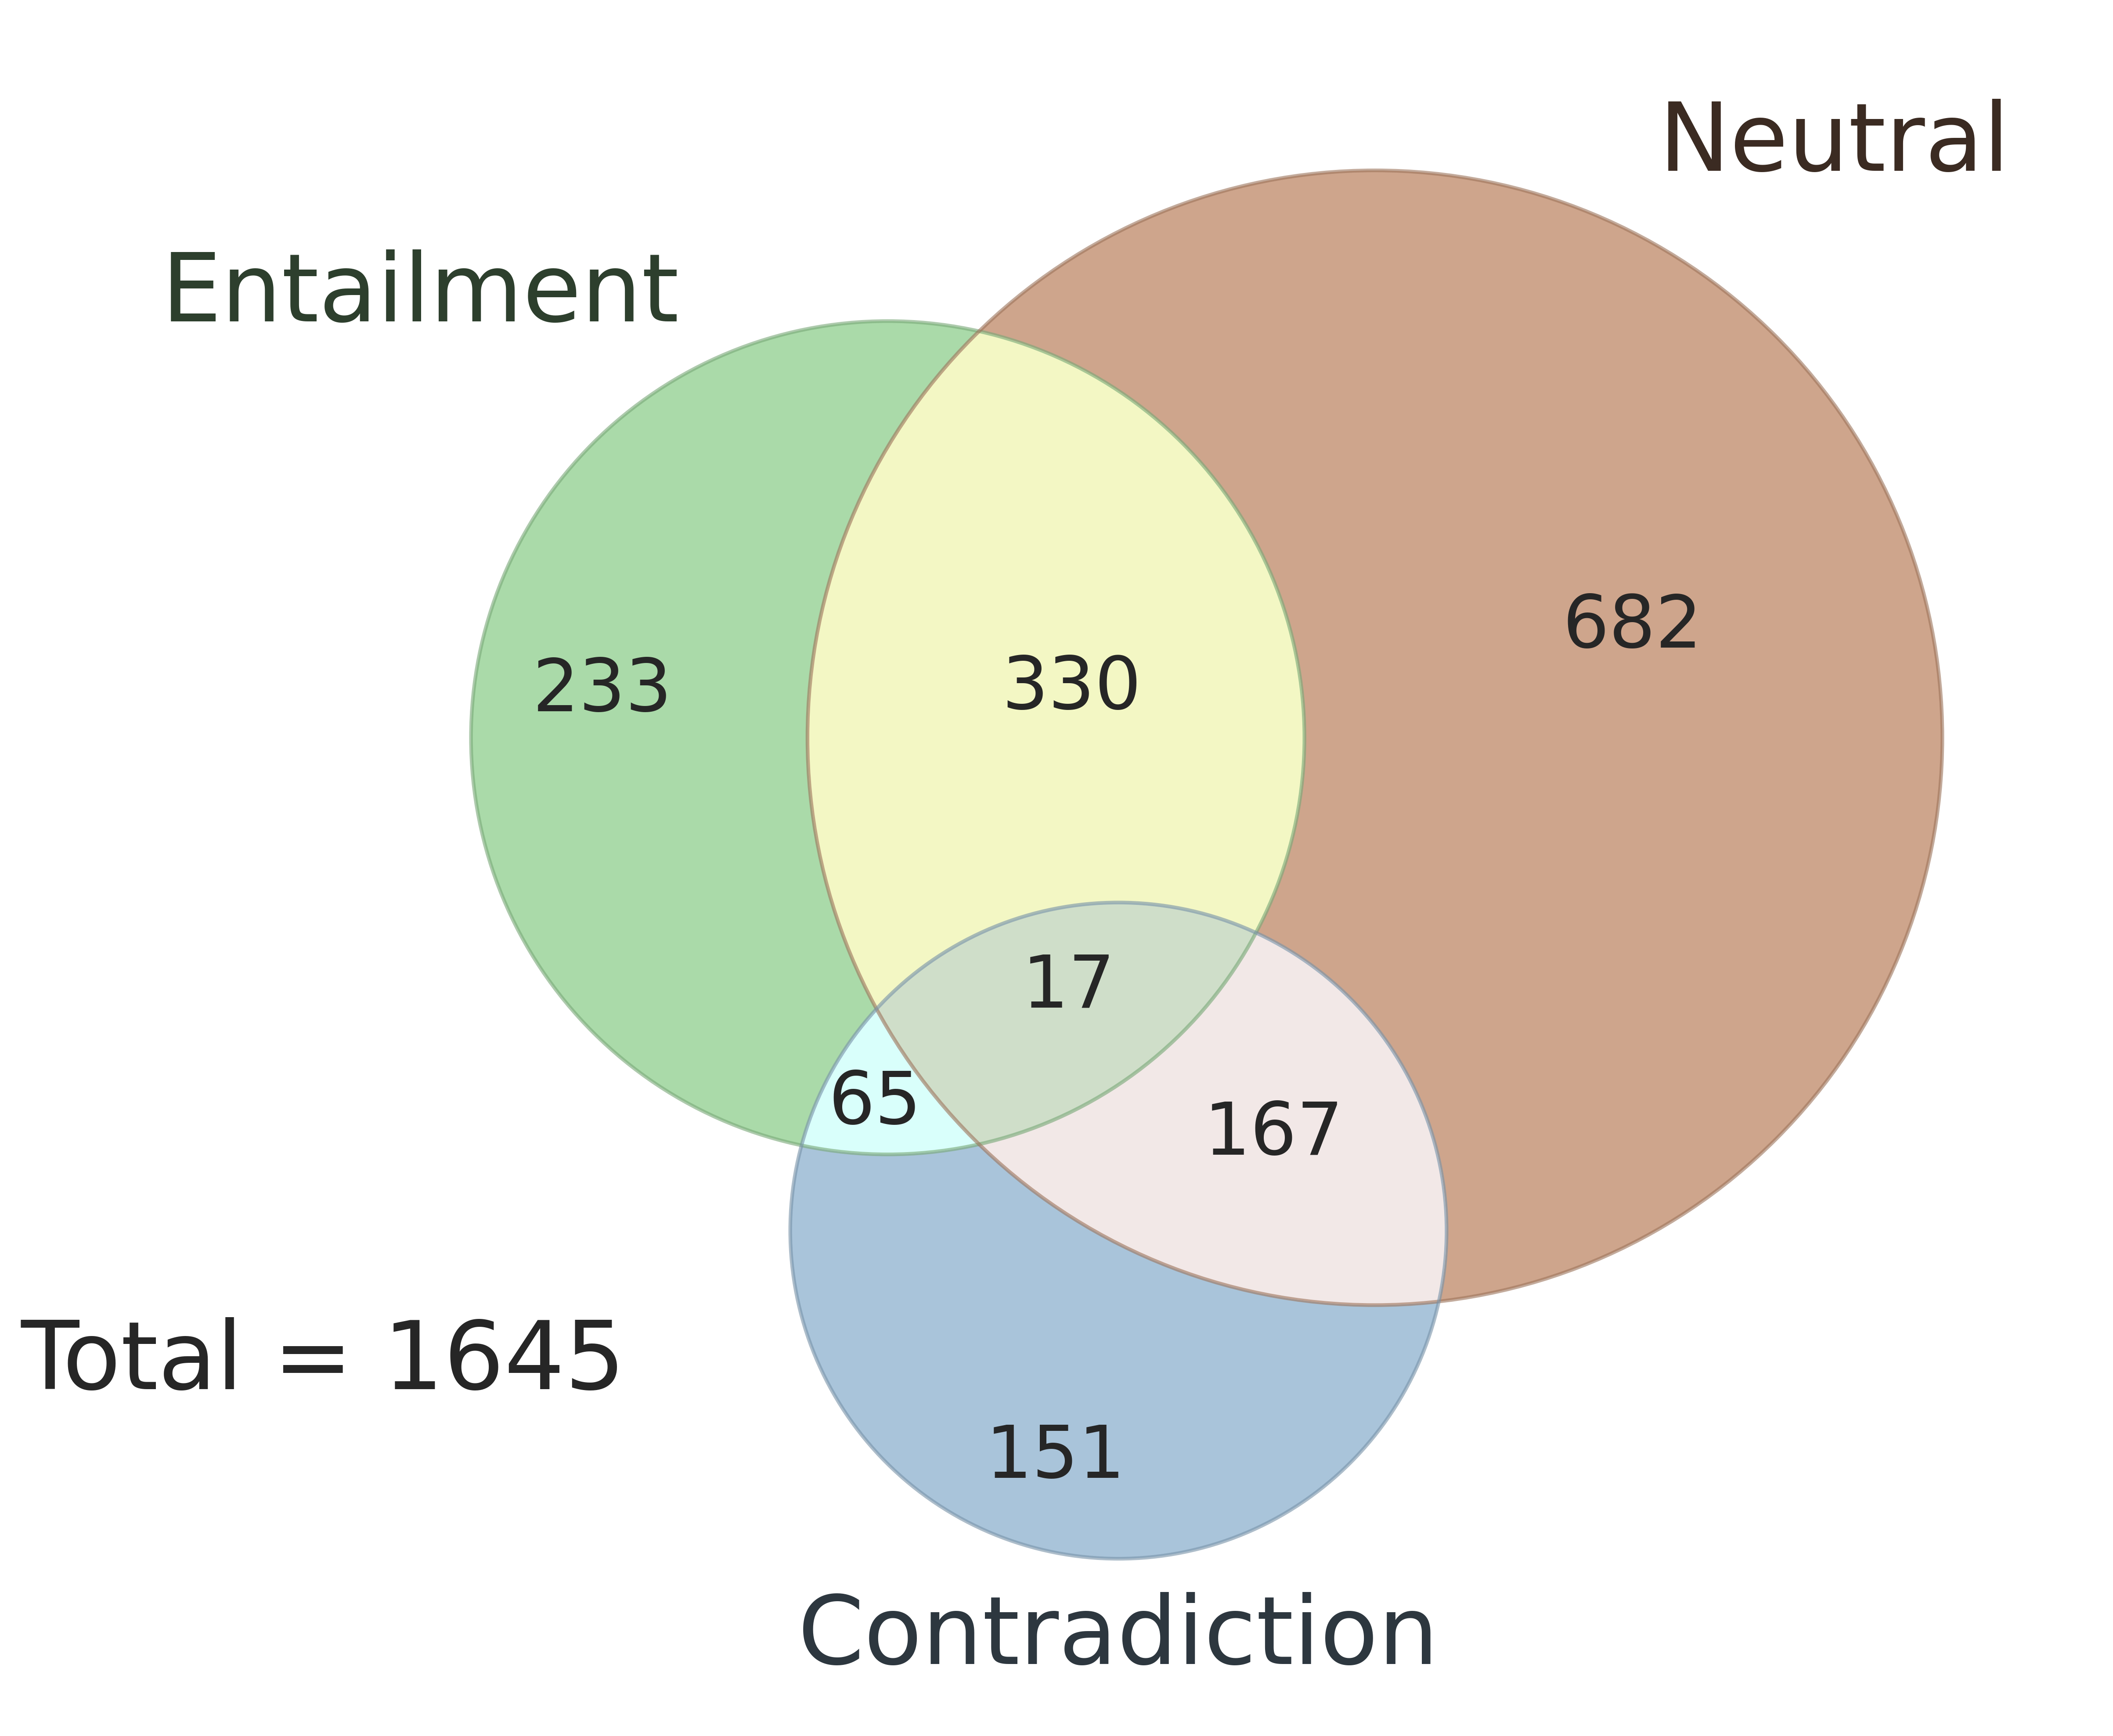

In [13]:
# entailment_set = set of example IDs that contain entailment label
plt.style.use('seaborn')
color_to_label = {
    'Entailment': '#95D194',
    'Neutral': '#C28F70',
    'Contradiction': '#94B6D1'
}

fig, ax = plt.subplots(figsize=(4,4), dpi=1200)

subsets = [label_dist[k] for k in key_order]
v = venn3(subsets=subsets, set_labels=color_to_label.keys(), set_colors=color_to_label.values(), alpha=0.8)
for text, h in zip(v.set_labels, color_to_label.values()):
    text.set_fontsize(13)
    text.set_color(darken_color(h, amount=0.7))
    
c = venn3_circles(subsets=subsets, linestyle='solid', color='darkgray')
for circle, h in zip(c, color_to_label.values()):
    circle.set_lw(0.5)
    circle.set_alpha(0.6)
    circle.set_edgecolor(darken_color(h, amount=0.2))

plt.annotate('Total = 1645', xy=[0.01,0.2], xycoords='figure fraction', fontsize=13)
plt.tight_layout()
plt.savefig('figures/label_dist.png', dpi=300)

### other stats

In [14]:
num_examples = len(df.index)
num_ambiguous = len(df.loc[df['premise_ambiguous'] | df['hypothesis_ambiguous']])
print(f'Dataset size: {num_examples}')
print(f'Number of ambiguous examples: {num_ambiguous}')
print(f'Proportion of ambiguous examples: {num_ambiguous/num_examples}')

Dataset size: 1645
Number of ambiguous examples: 579
Proportion of ambiguous examples: 0.3519756838905775


In [15]:
print(f'Proportion of ambiguous examples where the premise is ambiguous: {len(df.loc[df["premise_ambiguous"]])/num_ambiguous}')

Proportion of ambiguous examples where the premise is ambiguous: 0.7426597582037997


In [16]:
print(f'Proportion of ambiguous examples where the hypothesis is ambiguous: {len(df.loc[df["hypothesis_ambiguous"]])/num_ambiguous}')

Proportion of ambiguous examples where the hypothesis is ambiguous: 0.32642487046632124


In [17]:
print(f'Proportion of ambiguous examples where both are ambiguous: {len(df.loc[df["hypothesis_ambiguous"] & df["premise_ambiguous"]])/num_ambiguous}')

Proportion of ambiguous examples where both are ambiguous: 0.0690846286701209


In [18]:
print(f'Proportion of ambiguous examples where EITHER P OR H is ambiguous (not both): {len(df.loc[df["hypothesis_ambiguous"] ^ df["premise_ambiguous"]])/num_ambiguous}')

Proportion of ambiguous examples where EITHER P OR H is ambiguous (not both): 0.9309153713298791


In [19]:
lens = [] # list of tuples of the form (ambiguous_sentence_len, [disambiguation_sentence_lens])
for i, row in df.iterrows():
    for sentence_key in ['premise', 'hypothesis']:
        if row[f'{sentence_key}_ambiguous']:
            a_len = len(row[f'{sentence_key}'].split())
            disambiguations = [d[f'{sentence_key}'] for d in row['disambiguations']]
            d_lens = [len(d.split()) for d in disambiguations]
            lens.append((a_len, d_lens))

len_diff = []
for a_len, d_lens in lens:
    for d_len in d_lens:
        len_diff.append(d_len-a_len)
        
print(f'Mean difference in number of words between ambiguous sentence and its disambiguation: {np.mean(len_diff)}')

Mean difference in number of words between ambiguous sentence and its disambiguation: 2.36144578313253


In [20]:
num_disambiguations_counter = Counter()
for i, row in df.iterrows():
    for sentence_key in ['premise', 'hypothesis']:
        if row[f'{sentence_key}_ambiguous']:
            disambiguations = [d[f'{sentence_key}'] for d in row['disambiguations']]
            num_disambiguations = len(set(disambiguations))
            num_disambiguations_counter[num_disambiguations] += 1

In [21]:
{k:v/sum(num_disambiguations_counter.values()) for k,v in num_disambiguations_counter.items()}

{2: 0.975767366720517, 4: 0.0016155088852988692, 3: 0.022617124394184167}